In [1]:
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


# Content table

1. Client
2. Server

## Installing dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import datetime
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import color
import os
import multiprocessing as mp
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cores = mp.cpu_count()
c = color.clr()
print(c.SUCCESS('Day:'), datetime.datetime.now())
print(c.SUCCESS('Device:'), device)
print(c.SUCCESS('Core:'), cores)

/home/quachnam/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Day: 2023-05-24 13:59:42.736323
Device: cpu
Core: 8


# Step 0: Preparation

## Loading the data

In [68]:
BATCH_SIZE = 16
name_client = 'mias'

In [77]:
def pre_process(img):
    img = img.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img)
    return img_clahe

transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5), (0.5)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),
                                    # transforms.RandomRotation(30),
                                    transforms.Resize((227,227))])
# --- Data ---
class Dataset():
    def __init__(self, path_data, transform=None):
        self.path_data = path_data
        self.df = pd.read_csv(f'{self.path_data}/description.csv')
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = f'{self.path_data}/{self.df.iloc[index].Path_save}'
        image = cv2.imread(image_path, 0)
        if self.transform:
            image = pre_process(image)
            image_trans = self.transform(image)#['image']
        else:
            image_trans = image
        label = self.df.iloc[index]['Cancer']
        return image_trans, label
    
def Dataloader(path_data, transform=None, batch_size=16, size_train=0.8):
    dataset = Dataset(path_data=path_data, transform=transform)
    train_size = int(size_train * dataset.__len__())
    test_size = dataset.__len__() - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, test_dataloader

train_loader, test_loader = Dataloader(path_data=f'dataset/{name_client.upper()}-ROI-Mammography', transform=transform, batch_size=BATCH_SIZE)

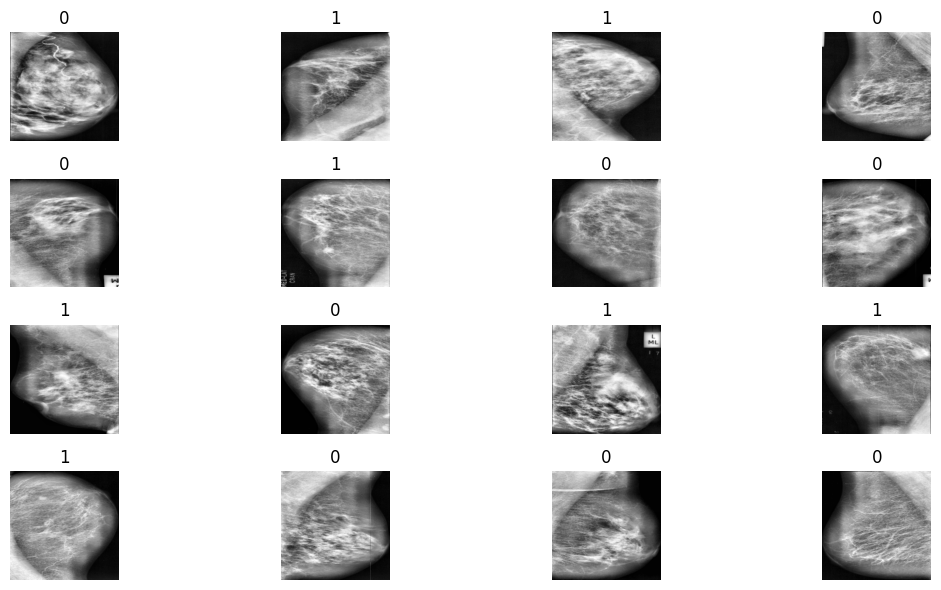

In [78]:
images, labels = next(iter(train_loader))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(labels[i].item())
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

# Step 1: Centralized Training with PyTorch

## Defining the model

In [80]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 1280)
        self.fc2 = nn.Linear(1280, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# sumamry of the model
net = Net()
from torchsummary import summary
summary(net, (1, 224, 224))

In [85]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

## Training the model

In [86]:
trainloader = train_loader
valloader = test_loader
net = Net().to(device)

for epoch in range(20):
    train(net, trainloader, 1, True)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, test_loader)

Epoch 1: train loss 0.04359637573361397, accuracy 0.4375
Epoch 1: validation loss 0.9246612787246704, accuracy 0.25
Epoch 1: train loss 0.17493149638175964, accuracy 0.5625
Epoch 2: validation loss 0.25017064809799194, accuracy 0.75
Epoch 1: train loss 0.127114936709404, accuracy 0.4375
Epoch 3: validation loss 0.24685722589492798, accuracy 0.25
Epoch 1: train loss 0.04496760666370392, accuracy 0.5625
Epoch 4: validation loss 0.15276691317558289, accuracy 0.75
Epoch 1: train loss 0.06049853935837746, accuracy 0.4375
Epoch 5: validation loss 0.2590789496898651, accuracy 0.25
Epoch 1: train loss 0.04609324783086777, accuracy 0.5625
Epoch 6: validation loss 0.1489657759666443, accuracy 0.75
Epoch 1: train loss 0.046611156314611435, accuracy 0.4375
Epoch 7: validation loss 0.25038349628448486, accuracy 0.25
Epoch 1: train loss 0.04255454242229462, accuracy 0.5625
Epoch 8: validation loss 0.1390238255262375, accuracy 0.75
Epoch 1: train loss 0.04214204102754593, accuracy 0.5
Epoch 9: valida

# Step 2: Federated Learning with Flower

## Updating model parameters

In [87]:
def get_parameters(net):
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

## Implementing a Flower client

In [88]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

## Using the Virtual Client Engine

In [93]:
def client_fn(name_client: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(device)

    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    train_loader, test_loader = Dataloader(path_data=f'dataset/{name_client.upper()}-ROI-Mammography', transform=transform, batch_size=BATCH_SIZE)

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, train_loader, test_loader)

## Starting the training

In [94]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if device.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-05-25 15:53:13,451 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-05-25 15:53:17,626	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-05-25 15:53:19,083 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2245252300.0, 'CPU': 8.0, 'memory': 4490504603.0, 'node:192.168.10.29': 1.0}
INFO flwr 2023-05-25 15:53:19,084 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-25 15:53:19,085 | server.py:273 | Requesting initial parameters from one random client
ERROR flwr 2023-05-25 15:53:21,561 | ray_client_proxy.py:72 | ray::launch_and_get_parameters() (pid=20505, ip=192.168.10.29)
  File "/home/quachnam/.local/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 135, in launch_and_get_parameters
    client: Client = _create_client(client_fn, cid)
  File "/home/quachnam/.local/lib/python3.10/site-packages/flwr/simulation/ray_tran

RayTaskError(FileNotFoundError): [36mray::launch_and_get_parameters()[39m (pid=20505, ip=192.168.10.29)
  File "/home/quachnam/.local/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 135, in launch_and_get_parameters
    client: Client = _create_client(client_fn, cid)
  File "/home/quachnam/.local/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 168, in _create_client
    client_like: ClientLike = client_fn(cid)
  File "/tmp/ipykernel_6444/803655287.py", line 9, in client_fn
  File "/tmp/ipykernel_6444/3807832444.py", line 35, in Dataloader
  File "/tmp/ipykernel_6444/3807832444.py", line 17, in __init__
  File "/home/quachnam/.local/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 912, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/home/quachnam/.local/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 577, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/home/quachnam/.local/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1407, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/home/quachnam/.local/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1661, in _make_engine
    self.handles = get_handle(
  File "/home/quachnam/.local/lib/python3.10/site-packages/pandas/io/common.py", line 859, in get_handle
    handle = open(
FileNotFoundError: [Errno 2] No such file or directory: 'dataset/0-ROI-Mammography/description.csv'

## Behind the scenes

## Where’s the accuracy?

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

# test

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 224, 224]              60
              ReLU-2          [-1, 6, 224, 224]               0
         MaxPool2d-3          [-1, 6, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             880
              ReLU-5         [-1, 16, 112, 112]               0
         MaxPool2d-6           [-1, 16, 56, 56]               0
            Conv2d-7           [-1, 32, 56, 56]           4,640
              ReLU-8           [-1, 32, 56, 56]               0
         MaxPool2d-9           [-1, 32, 28, 28]               0
           Linear-10                  [-1, 120]       3,010,680
             ReLU-11                  [-1, 120]               0
           Linear-12                   [-1, 84]          10,164
             ReLU-13                   [-1, 84]               0
           Linear-14                   

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import cv2
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split

import torch.nn as nn
import torch.nn.functional as F
import flwr as fl
import multiprocessing as mp
import color
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cores = mp.cpu_count()
c = color.clr()
print(c.SUCCESS('Day:'), datetime.datetime.now())
print(c.SUCCESS('Device:'), device)
print(c.SUCCESS('Core:'), cores)

def pre_process(img):
    img = img.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img)
    return img_clahe
# --- Data ---
class Dataset():
    def __init__(self, path_data, transform=None):
        self.path_data = path_data
        self.df = pd.read_csv(f'{self.path_data}/description.csv')
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = f'{self.path_data}/{self.df.iloc[index].Path_save}'
        image = cv2.imread(image_path, 0)
        if self.transform:
            image = pre_process(image)
            image_trans = self.transform(image)#['image']
        else:
            image_trans = image
        label = self.df.iloc[index]['Cancer']
        return image_trans, label
    
def Dataloader(path_data, transform=None, batch_size=16, size_train=0.8):
    dataset = Dataset(path_data=path_data, transform=transform)
    train_size = int(size_train * dataset.__len__())
    test_size = dataset.__len__() - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, test_dataloader

def show_image(dataset):
    img = dataset[0][0].squeeze()
    label = dataset[0][1]
    cv2.imshow(str(label.item()), img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# --- Model ---
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        loop = tqdm(trainloader, desc='Training')
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
            acc_cur = (torch.max(outputs.data, 1)[1] == labels).sum().item()/labels.size(0)
            loop.set_postfix(loss=loss.item(), acc=acc_cur)
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=2)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(name_client) -> FlowerClient:
    net = Net().to(device)
    train_loader, test_loader = Dataloader(path_data=f'dataset/{name_client.upper()}-ROI-Mammography', transform=transform, batch_size=32)
    return FlowerClient(name_client, net, train_loader, test_loader)

transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5), (0.5)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.Resize((227,227))])
cl1 = client_fn('mias')
cl1.fit()

Day: 2023-05-25 10:15:12.184021
Device: cpu
Core: 8
